In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Filter

Ảnh coi như là tín hiệu số 2D. Sử dụng các bộ lọc để cho ra các ảnh đáp ứng có các tính chất như mong muốn. 

Sử dụng đáp ứng xung là một ma trận kernel 2D. Áp dụng bộ lọc bằng cách sử dụng phép chập giữa ảnh với kernel tương ứng

#### Smoothing

Sử dụng kernel ứng với bộ lọc thông thấp để làm mịn (mờ) ảnh. Ví dụ bộ lọc trung bình và bộ lọc gaussian.

Thực hiện bộ lọc thông qua hàm `filter2D` nếu có ma trận kernel.
Hoặc sử dụng hàm `blur`, `GaussianBlur` - OpenCV tự tạo ra kernel trung bình, gaussian tương ứng với các tham số đầu vào

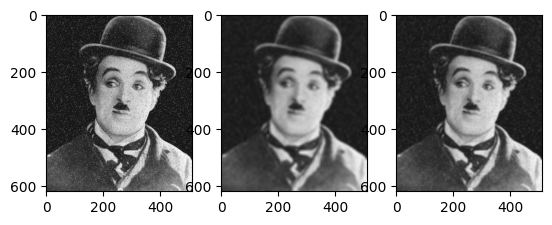

In [10]:
img = cv.imread('images/noisy.png')

mean_kernel = np.ones((11, 11), dtype=np.float32) / 121 # kernel trung bình kích thước 11x11

mean_img = cv.filter2D(img, ddepth=-1, kernel=mean_kernel) # tham số ddepth ứng với phần depth của ảnh (không rõ) là gì
gauss_img = cv.GaussianBlur(img, (11, 11), 0, 0) # kernel gaussian kích thước 11x11

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(mean_img)
plt.subplot(1, 3, 3)
plt.imshow(gauss_img)

Một số loại lọc khác mà không sử dụng phép chập với kernel: median blurring và bilateral filtering
* median blurring - thay giá trị pixel bằng giá trị median trong kernel cục bộ tương ứng
    - Sử dụng hàm `medianBlur`
* bilateral filtering - khử nhiễu và đồng thời giữ nguyên các pixel cạnh được rõ nét
    - Sử dụng hàm `bilateralFilter`

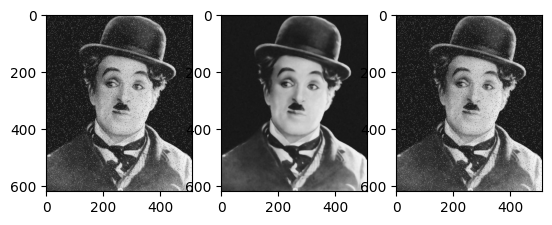

In [13]:
img = cv.imread('images/noisy.png')

median_img = cv.medianBlur(img, 5) # kernel cục bộ kích thước 5x5
bilateral_img = cv.bilateralFilter(img, 5, 75, 75) 

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(median_img)
plt.subplot(1, 3, 3)
plt.imshow(bilateral_img)

## Image gradients

Việc tính đạo hàm đó có thể thực hiện bằng bộ lọc ứng với công thức xấp xỉ đạo hàm trên tín hiệu số rời rạc. Ví dụ theo chiều x - $\begin{bmatrix}1 & 0 & -1\end{bmatrix}$, theo chiều y - $\begin{bmatrix}1 \\ 0 \\ -1\end{bmatrix}$.

#### Sobel filter

Sobel filter là kết hợp kernel làm mịn ảnh, khử nhiễu (gaussian) với kernel tính đạo hàm. Việc tính đạo hàm theo chiều x, y nên sẽ có hai kernel tương ứng là SobelX và SobelY. Cần phải đạo hàm là do vì có nhiễu nên giá trị đạo hàm cũng bị ảnh hưởng bởi các nhiễu đó.

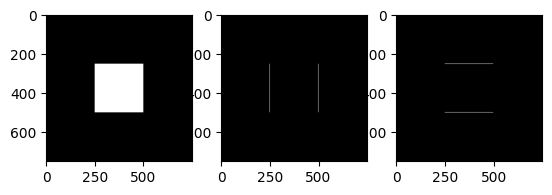

In [34]:
img = np.zeros((750, 750))
img[250:500, 250:500] = 255

img_dx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3) # đạo hàm theo trục x (theo cột)
img_dy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3) # đạo hàm theo trục y (theo hàng)

img_dx = np.square(img_dx)
img_dy = np.square(img_dy) 

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
# những đoạn pixel trắng ứng với giá trị đạo hàm ở đó rất cao ứng với vị trí thay đổi từ pixel trắng->đen và ngược lại
plt.subplot(1, 3, 2)
plt.imshow(img_dx, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(img_dy, cmap='gray')

## Canny edge detection

Là một thuật toán gồm nhiều bước để xác định các pixel cạnh trong ảnh. Sử dụng thông qua hàm `Canny` của OpenCV

1. Sử dụng bộ lọc gaussian để khử nhiễu (ví dụ kích thước 5x5)
2. Tính đạo hàm theo chiều x, y bằng bộ lọc Sobel. Tương ứng đầu ra là các ma trận $G_x$, $G_y$
    - Tính độ lớn của gradient tại từng pixel bằng $\sqrt{G_x^2 + G_y^2}$
    - Hướng của gradient tại từng pixel bằng $\theta = \tan^{-1}(\dfrac{G_y}{G_x})$
3. **Non-maximum Suppression** - loại bỏ các pixel có gradient không phải cực đại cục bộ 
     - Dựa vào giá trị hướng gradient $\theta$ xác định hai pixel lân cận. Ví dụ góc $\theta$ bằng 45 độ thì pixel lân cận với pixel $(x,y)$ là $(x+1,y+1)$ và $(x-1,y-1)$.
     - Nếu độ lớn gradient tại $(x,y)$ lớn hơn ở cả $(x+1,y+1)$ và $(x-1,y-1)$ thì giữ nguyên, ngược lại loại bỏ độ lớn gradient tại ô đó (gán bằng giá trị 0).
4. **Hysteresis Thresholding** - đặt ngưỡng `minVal` và `maxVal` để xác định pixel cạnh
    - Những pixel có độ lớn gradient trên `maxVal` thì được gọi là strong-edge, chắc chắn được gán giá trị 1 ứng với pixel edge
    - Những pixel có độ lớn gradient dưới `minVal` thì bị loại bỏ, gán giá trị 0
    - Những pixel còn lại có độ lớn nằm giữa `minVal` và `maxVal` được gọi là weak-edge sẽ được gán giá trị 1 nếu tồn tại đường đi từ một pixel strong-edge tới pixel đó mà chỉ đi qua các pixel strong-edge và weak-edge

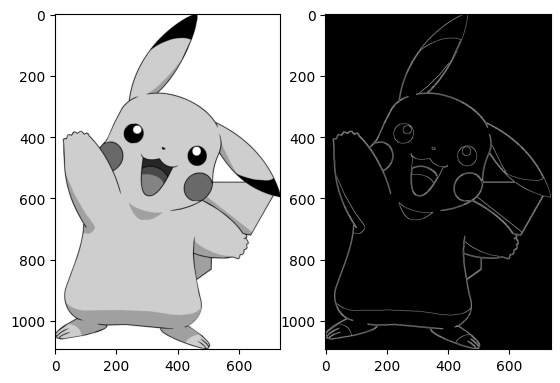

In [41]:
img = cv.imread('images/pikachu.jpg')

img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
edges = cv.Canny(img, 100, 200) # Hai ngưỡng minVal=100, maxVal=200

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')